Firstly, we need to import all necessary libraries.


#Necessary imports



In [5]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from  sklearn.model_selection import GridSearchCV 

Then, we load the file

In [6]:
df = pd.read_csv("creditCard.csv")
labels  = pd.read_csv("creditCardLabel.csv")


And check the first 5 rows

In [7]:
df.head()

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2
2,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2
3,5009749,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2
4,5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2


We can already see that the 1st row will cause trouble for our models, that's why we can proceed with deletion

In [8]:
df_transformation = df.copy()
df_transformation.drop(df.iloc[0].name, inplace=True)

Let's investigate the ```[Car_owner]``` and ```[Propert_Owner]``` columns

In [9]:
uniqVal = pd.concat([df['Car_Owner'], df['Propert_Owner'],]).unique()

print(uniqVal)

['Y' 'N']


As we can see, they are boolean columns, so we should make them boolean instead of string

In [10]:
df_transformation['Car_Owner'] = df['Car_Owner'].map({'Y': 1, 'N': 0})
df_transformation['Propert_Owner'] = df['Propert_Owner'].map({'Y': 1, 'N': 0})


Columns ```[Employed_years]``` and ```[Birthday_count]``` appear to be quite hard to read, let's change that.

In [11]:
# Convert Employed_days to years
df_transformation['Employed_years'] = df_transformation['Employed_days'] / 365

# Convert Birthday_count to years
df_transformation['Age'] = df_transformation['Birthday_count'] / -365

# Round the values to two decimal places
df_transformation['Employed_years'] = df_transformation['Employed_years'].round(2)
df_transformation['Age'] = df_transformation['Age'].round(2)

# Drop the original columns
df_transformation.drop(['Employed_days', 'Birthday_count'], axis=1, inplace=True)




Additionally, we can change ```[Age]``` column further, by creating age brackets

In [12]:
# Define the age brackets
age_brackets = [18, 26, 35, 46, 55, 66, 200]

# Define the labels for the age brackets
age_labels = ['18-25', '26-34', '35-45', '46-54', '55-65', '66+']

# Create a new column 'Age Bracket' based on the 'Age' column
df_transformation['Age Bracket'] = pd.cut(df_transformation['Age'], bins=age_brackets, labels=age_labels, right=False)


Perhaps, we only need to know if person is employed or not, regardless of the time employed

In [13]:
df_transformation['Is_Employed'] = (df_transformation['Employed_years'] < 0).astype(int)


Becuase column ```[GENDER]``` also consist of letters, I've decided to change the name of the column to ```[isMale]```, and make it binary

In [14]:
# Convert Employed_days to years
df_transformation['isMale'] = df_transformation['GENDER'].apply(lambda x: 1 if x == 'M' else 0)
df_transformation.drop(["GENDER"],axis=1,inplace=True)

What we should do next is changing the categorical variables into numerical, in order to do so we will use LabelEncoding (for now), so the NaN values will also be granted a label, that's one approach we will use

## Ignoring the NA's





In [15]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Iterate over each column in the DataFrame
for column in df_transformation.columns:
    # Check if the column is of object type (categorical)
    if df_transformation[column].dtype == 'object':
        # Use label encoder to transform the column
        df_transformation[column] = label_encoder.fit_transform(df_transformation[column])



According to data source, non-positive value of column ```Employed Days``` indicated the years the person is working. However, it is more logical, that this column should be positive when person is working and negative when not.

In [16]:
df_transformation["Employed_years"] = df_transformation["Employed_years"] * -1


In [17]:
df_transformation

,Ind_ID,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,Employed_years,Age,Age Bracket,Is_Employed,isMale
1,5009744,1,0,0,315000.0,0,1,1,1,1,1,1,0,18,2,1.61,37.14,35-45,1,0
2,5009746,1,0,0,315000.0,0,1,1,1,1,1,1,0,18,2,1.61,NaN,NaN,1,0
3,5009749,1,0,0,NaN,0,1,1,1,1,1,1,0,18,2,1.61,37.14,35-45,1,0
4,5009752,1,0,0,315000.0,0,1,1,1,1,1,1,0,18,2,1.61,37.14,35-45,1,0
5,5009753,1,0,0,315000.0,1,1,1,1,1,1,1,0,18,2,1.61,37.14,35-45,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,5028645,0,1,0,NaN,0,1,1,1,1,0,0,0,10,2,5.98,32.76,26-34,1,0
1544,5023655,0,0,0,225000.0,0,2,3,1,1,0,0,0,0,1,3.31,28.02,26-34,1,0
1545,5115992,1,1,2,180000.0,3,1,1,1,1,0,0,0,10,4,6.79,36.09,35-45,1,1
1546,5118219,1,0,0,270000.0,3,4,0,1,1,1,1,0,4,2,1.77,41.90,35-45,1,1


### Hypothesis testing


Now we can proceed with some hypothesis testing or other statistical test in order to find out something more.

Shapiro-Wilk Test

In [18]:
for column in df_transformation.select_dtypes(include=np.number).columns:
    stat, p = shapiro(df_transformation[column])
    print('Column:', column)
    print('Test Statistic:', stat)
    if(p > 0.05):
        print('Probably Gaussian')
    else:
        print('Probably not Gaussian')


Column: Ind_ID
Test Statistic: 0.9490448356105866
Probably not Gaussian
Column: Car_Owner
Test Statistic: 0.6226974818552935
Probably not Gaussian
Column: Propert_Owner
Test Statistic: 0.6019987030301852
Probably not Gaussian
Column: CHILDREN
Test Statistic: 0.5506461588590481
Probably not Gaussian
Column: Annual_income
Test Statistic: nan
Probably not Gaussian
Column: Type_Income
Test Statistic: 0.742107350724974
Probably not Gaussian
Column: EDUCATION
Test Statistic: 0.6185074818915145
Probably not Gaussian
Column: Marital_status
Test Statistic: 0.7105914736188281
Probably not Gaussian
Column: Housing_type
Test Statistic: 0.33994336455900376
Probably not Gaussian
Column: Mobile_phone
Test Statistic: 1.0
Probably Gaussian
Column: Work_Phone
Test Statistic: 0.4986439868343323
Probably not Gaussian
Column: Phone
Test Statistic: 0.581621744266775
Probably not Gaussian
Column: EMAIL_ID
Test Statistic: 0.3269528126775406
Probably not Gaussian
Column: Type_Occupation
Test Statistic: 0.88020

/home/filki/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [19]:
df_transformation.dropna(inplace = True)

In [20]:
df_transformation.isna().sum()

Ind_ID             0
Car_Owner          0
Propert_Owner      0
CHILDREN           0
Annual_income      0
Type_Income        0
EDUCATION          0
Marital_status     0
Housing_type       0
Mobile_phone       0
Work_Phone         0
Phone              0
EMAIL_ID           0
Type_Occupation    0
Family_Members     0
Employed_years     0
Age                0
Age Bracket        0
Is_Employed        0
isMale             0
dtype: int64

### EDA using visualizations


In [21]:
df_transformation_without_age_brackets = df_transformation.drop(columns = ["Age Bracket"], axis = 1)

<Axes: >

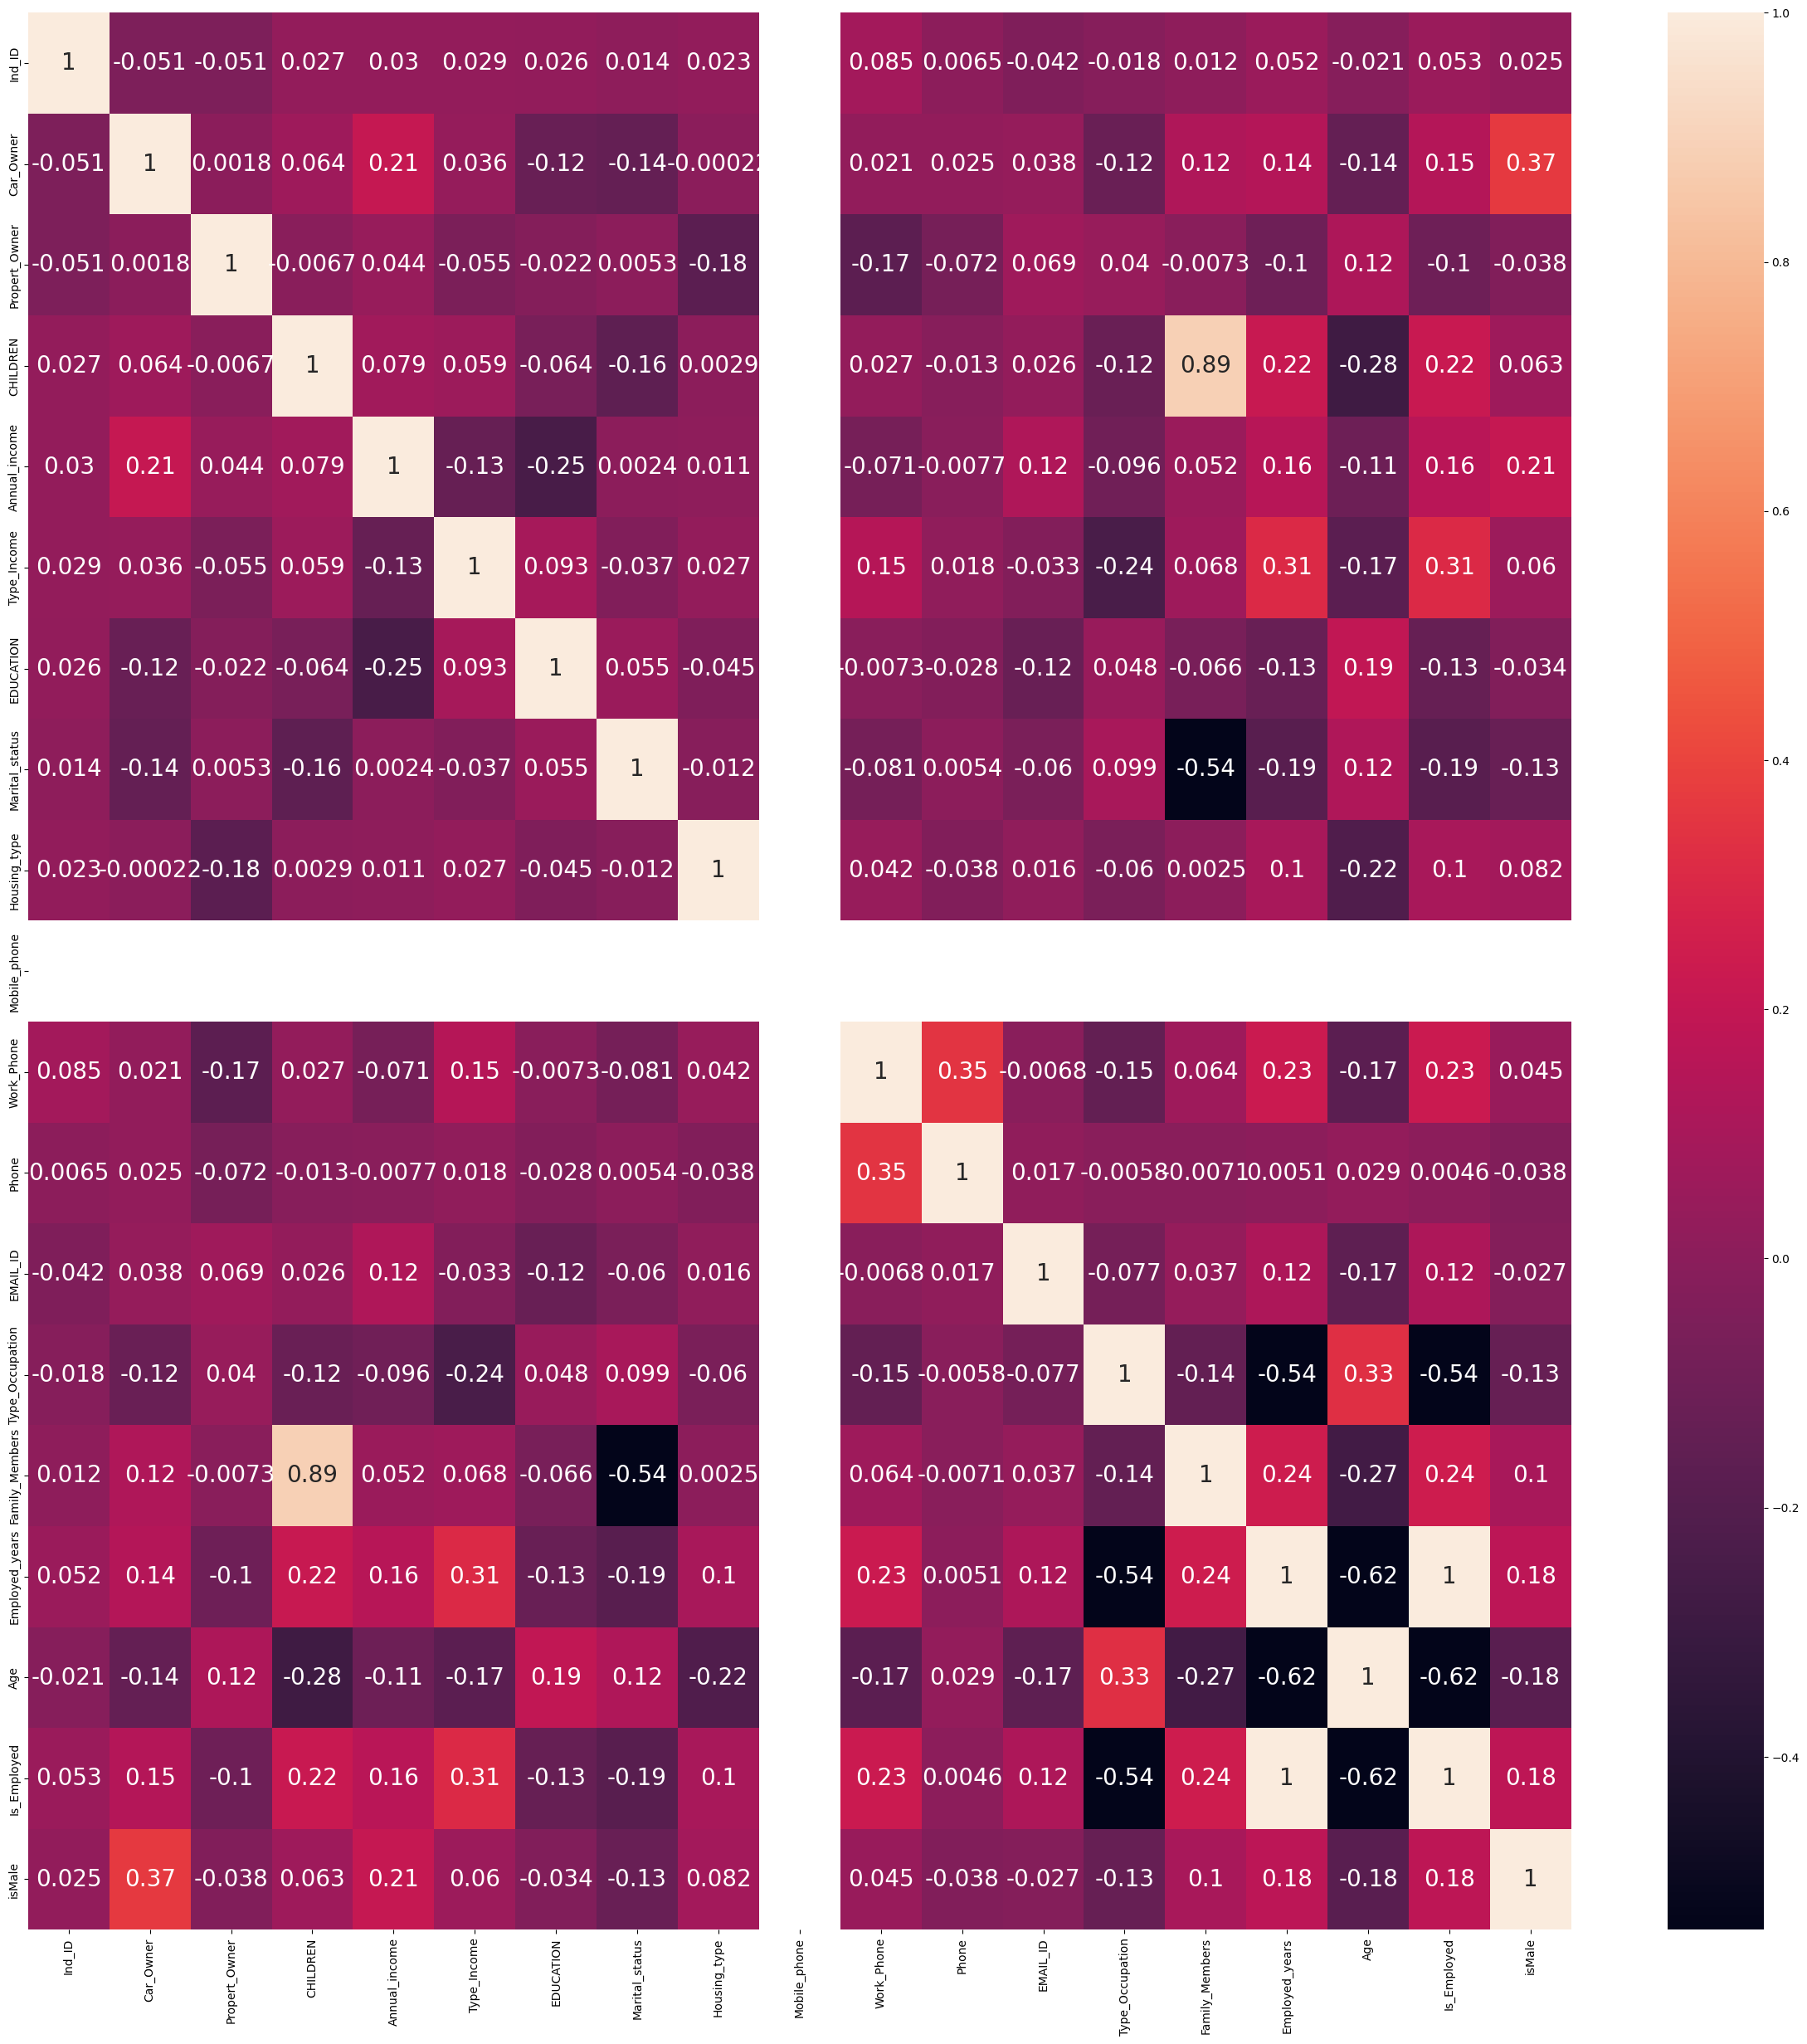

In [22]:
plt.subplots(figsize=(30,30))
sns.heatmap(df_transformation_without_age_brackets.corr(),annot=True,robust = True,annot_kws={'size': 20})

As we can see, the correlation heatmap is not readable due to huge amount of variables. It is perfect time to conduct some feature importance/engineering techniques, such as PCA
We will use ```pipeline``` solution from ```scikit-learn```.

In [39]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA

# Define the steps in the pipeline
steps = [
    ('scaler', StandardScaler()),  # Standardize the features
    ('pca', PCA(n_components=2))  # Perform PCA with 2 components
]

# Create the pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the data
pipeline.fit(df_transformation_without_age_brackets)


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2))])

### MODEL 1 - HistGradientBoosting 

In [24]:
df_with_labels = pd.merge(df_transformation_without_age_brackets, labels, on='Ind_ID', how='left')
df_with_labels


,Ind_ID,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,Employed_years,Age,Is_Employed,isMale,label
0,5009744,1,0,0,315000.0,0,1,1,1,1,1,1,0,18,2,1.61,37.14,1,0,1
1,5009752,1,0,0,315000.0,0,1,1,1,1,1,1,0,18,2,1.61,37.14,1,0,1
2,5009753,1,0,0,315000.0,1,1,1,1,1,1,1,0,18,2,1.61,37.14,1,0,1
3,5009754,1,0,0,315000.0,0,1,1,1,1,1,1,0,18,2,1.61,37.14,1,0,1
4,5009894,0,0,0,180000.0,1,4,1,1,1,0,0,0,18,2,-1000.67,60.64,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497,5118268,1,0,1,360000.0,2,4,1,1,1,0,1,0,4,3,9.69,30.94,1,1,0
1498,5023655,0,0,0,225000.0,0,2,3,1,1,0,0,0,0,1,3.31,28.02,1,0,0
1499,5115992,1,1,2,180000.0,3,1,1,1,1,0,0,0,10,4,6.79,36.09,1,1,0
1500,5118219,1,0,0,270000.0,3,4,0,1,1,1,1,0,4,2,1.77,41.90,1,1,0


In [25]:
X = df_with_labels.drop("label",axis = 1)
X

,Ind_ID,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,Employed_years,Age,Is_Employed,isMale
0,5009744,1,0,0,315000.0,0,1,1,1,1,1,1,0,18,2,1.61,37.14,1,0
1,5009752,1,0,0,315000.0,0,1,1,1,1,1,1,0,18,2,1.61,37.14,1,0
2,5009753,1,0,0,315000.0,1,1,1,1,1,1,1,0,18,2,1.61,37.14,1,0
3,5009754,1,0,0,315000.0,0,1,1,1,1,1,1,0,18,2,1.61,37.14,1,0
4,5009894,0,0,0,180000.0,1,4,1,1,1,0,0,0,18,2,-1000.67,60.64,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497,5118268,1,0,1,360000.0,2,4,1,1,1,0,1,0,4,3,9.69,30.94,1,1
1498,5023655,0,0,0,225000.0,0,2,3,1,1,0,0,0,0,1,3.31,28.02,1,0
1499,5115992,1,1,2,180000.0,3,1,1,1,1,0,0,0,10,4,6.79,36.09,1,1
1500,5118219,1,0,0,270000.0,3,4,0,1,1,1,1,0,4,2,1.77,41.90,1,1


In [26]:
y = df_with_labels['label']
y

0       1
1       1
2       1
3       1
4       1
       ..
1497    0
1498    0
1499    0
1500    0
1501    0
Name: label, Length: 1502, dtype: int64

In [27]:
model1_ignored_na = HistGradientBoostingClassifier()
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)

model1_ignored_na.fit(X_train,y_train)


HistGradientBoostingClassifier()

In [28]:
model1_ignored_na.score(X_test,y_test)

0.9354838709677419

In [29]:
y_pred = model1_ignored_na.predict(X_test)

In [30]:
report_raw = classification_report(y_test, y_pred)
report_table_raw = pd.DataFrame([x.split() for x in report_raw.split('\n')[2:-5]], columns=['class', 'precision', 'recall', 'f1-score', 'support'])
print(report_table_raw)


  class precision recall f1-score support
0     0      0.95   0.98     0.96     451
1     1      0.70   0.51     0.59      45


In [31]:
model1_ignored_na_PARAMS = {
    "learning_rate": [0.1, 0.01, 0.001],
    "max_iter": [100, 200, 300],
    "max_leaf_nodes": [31, 41, 51],
    "min_samples_leaf": [20, 30, 40]
}

In [32]:
model1_ignored_na_grid = GridSearchCV(model1_ignored_na, model1_ignored_na_PARAMS, cv=5, n_jobs=-1)
model1_ignored_na_grid.fit(X_train, y_train)
model1_ignored_na_grid.best_params_

{'learning_rate': 0.1,
 'max_iter': 300,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20}

In [33]:
model1_ignored_na_grid.score(X_test, y_test)
report_GSCV = classification_report(y_test, model1_ignored_na_grid.predict(X_test))
report_table_GSCV = pd.DataFrame([x.split() for x in report_GSCV.split('\n')[2:-5]], columns=['class', 'precision', 'recall', 'f1-score', 'support'])
print(report_GSCV)


              precision    recall  f1-score   support

           0       0.95      0.98      0.97       451
           1       0.71      0.49      0.58        45

    accuracy                           0.94       496
   macro avg       0.83      0.73      0.77       496
weighted avg       0.93      0.94      0.93       496



In [34]:
print(model1_ignored_na_grid.score(X_test, y_test))

0.9354838709677419
